# Predicting housing prices: Data preprocessing

This project was completed as part of the Kaggle competition [House Prices: Advaned Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). **The goal is to build a model for predicting house prices**.

The dataset comes from the Ames Housing Data project, which collected information on homes in Ames, Iowa from 2006 to 2010. Each of the 2,919 observations represent the sale of an individual home, and contains 81 features useful for appraising the value of each home.

My general approach is split between two notebooks:

1. Perform data preprocessing, including data exploration, cleaning and feature engineering (**this notebook**)
2. Build a model to predict house prices, and then assess its performance in terms of predictive accuracy

## About this notebook

This notebook takes the original data as supplied by Kaggle, and performs all data cleaning and data preprocessing steps needed for building the predictive models in scikit-learn. Steps taken include:
1. Data exploration (assessing missing data/duplicates)
2. Feature engineering (creating/dropping variables)
3. Feature preprocessing (imputation, one-hot encoding, standardizing)

## Data exploration

In [1]:
# begin by importing all necessary libraries for this notebook:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dfply import *
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import pickle

# for inline plotting:

%matplotlib inline

# seems like the FutureWarnings I'm getting are a bug so ignore

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Note that the data have already been split into training and test sets for model assessment. I read these in, and then combine them to make cleaning and exploration easier. 

In [2]:
# import original train/test sets:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# create variable to ID train and test sets
train['dataSubset'] = 'train'
test['dataSubset'] = 'test'

# create SalePrice in test set & initialize with NaNs
test['SalePrice'] = np.nan

# reorder variables to match train
trainColumns = train.columns
test = test[trainColumns]

# combine train/test sets by stacking
trainTest = pd.concat([train, test], ignore_index = True)

# should have 1460 train & 1459 test--looks good!
trainTest['dataSubset'].value_counts()

train    1460
test     1459
Name: dataSubset, dtype: int64

Begin by getting a sense of the data, including data types and summary statistics/visualizations for SalePrice. Based on how Python read-in the data, the data have a similar number of categorical and numeric variables. 

In [3]:
# data types across features

trainTest.dtypes.value_counts()

object     44
int64      26
float64    12
dtype: int64

Based on the summary statistics & plots below, $SalePrice$ is heavily skewed-right due to a few homes that have a very high sale price. Since $SalePrice$ is $>0$, it makes sense to instead work with the $\log(SalePrice)$ to get a nice Normally distributed target variable.

Minimum price: $34,900.00
Maximum price: $755,000.00
Average price: $180,921.20
Median price: $163,000.00
Standard deviation of prices: $79,415.29


Text(0.5, 1.0, 'Log of Target Variable')

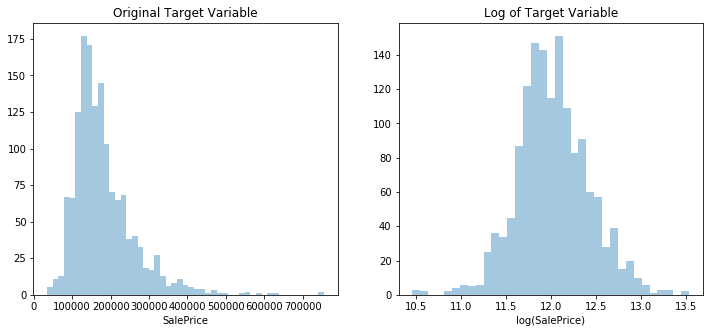

In [4]:
# summary of response variable

print("Minimum price: ${:,.2f}".format(np.min(trainTest['SalePrice'])))
print("Maximum price: ${:,.2f}".format(np.max(trainTest['SalePrice'])))
print("Average price: ${:,.2f}".format(np.mean(trainTest['SalePrice'])))
print("Median price: ${:,.2f}".format(np.nanmedian(trainTest['SalePrice'])))
print("Standard deviation of prices: ${:,.2f}".format(np.std(trainTest['SalePrice'])))

# histogram of SalePrice & log(SalePrice)

plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(train['SalePrice'],kde=False)
plt.title('Original Target Variable')
plt.subplot(122)
sns.distplot(np.log(train['SalePrice']),kde=False)
plt.xlabel('log(SalePrice)')
plt.title('Log of Target Variable')

### Assess extent of missingness

6 features present more than 17% missingness (about 500/2919 total observations). More than 3/4 of the data is missing for $Fence$, $Alley$, $MiscFeature$ and $PoolQC$. After looking at the codebook, NaN for most of these features actually means the house *did not have* the feature, and so NaN should really be relabeled as 'None'. For all other variables, I'm comfortable using imputation methods to replace.

In [5]:
# calculate percent missing for each feature by data subset
# show only when > 0 is missing

(round(trainTest.isnull().mean() * 100,2)[round(trainTest.isnull().mean() * 100,2) > 0]
     .sort_values(ascending=False))

PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
SalePrice       49.98
FireplaceQu     48.65
LotFrontage     16.65
GarageYrBlt      5.45
GarageFinish     5.45
GarageQual       5.45
GarageCond       5.45
GarageType       5.38
BsmtCond         2.81
BsmtExposure     2.81
BsmtQual         2.77
BsmtFinType2     2.74
BsmtFinType1     2.71
MasVnrType       0.82
MasVnrArea       0.79
MSZoning         0.14
BsmtFullBath     0.07
BsmtHalfBath     0.07
Functional       0.07
Utilities        0.07
BsmtFinSF2       0.03
BsmtUnfSF        0.03
BsmtFinSF1       0.03
TotalBsmtSF      0.03
SaleType         0.03
KitchenQual      0.03
Exterior2nd      0.03
Exterior1st      0.03
GarageCars       0.03
GarageArea       0.03
Electrical       0.03
dtype: float64

#### Take care of categorical features that need NaN replaced with 'None'

In [6]:
# list of features which need NaN replaced with 'None'

replaceNaN = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
              'GarageType','GarageFinish','GarageQual','GarageCond',
              'BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond',
              'BsmtQual']

# look to see if there's already a 'none' category

for i in replaceNaN:
    print(trainTest[i].unique())

[nan 'Ex' 'Fa' 'Gd']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['TA' 'Gd' nan 'Fa' 'Po']
['Gd' 'TA' 'Ex' nan 'Fa']


In [7]:
# there's not, so replace NaN with 'none'

trainTest[replaceNaN] = trainTest[replaceNaN].fillna(value='None')

# looks ok
for i in replaceNaN:
    print(trainTest[i].unique())

['None' 'Ex' 'Fa' 'Gd']
['None' 'Shed' 'Gar2' 'Othr' 'TenC']
['None' 'Grvl' 'Pave']
['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
['RFn' 'Unf' 'Fin' 'None']
['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' 'None']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
['TA' 'Gd' 'None' 'Fa' 'Po']
['Gd' 'TA' 'Ex' 'None' 'Fa']


There's one case within $MasVnrType$ that is missing, but has a credible value for $MasVnrArea$, which suggests that it's a true missing value. When replacing 'NaN' with 'None', ignore this case.

#### Take care of numeric features that need 'NaN' replaced with 0

$LotFrontage$ represents the number of feet from the house. Here, I'm looking at the lower end of the distribution of $LotFrontage$. It seems reasonable that 'NaN' here could actually mean 0 (no street connected), so I move forward by making such replacement.

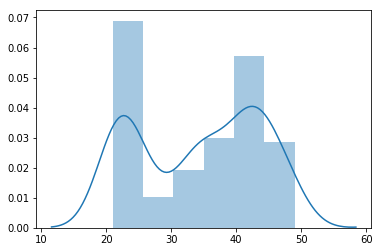

In [8]:
sns.distplot(trainTest.loc[(trainTest['LotFrontage'].notna()) & (trainTest['LotFrontage'] < 50),['LotFrontage']])

In [9]:
# replace NaN with 0 for this feature

trainTest['LotFrontage'] = trainTest['LotFrontage'].fillna(value=0)

In [10]:
# recalculate missingness

(round(trainTest.isnull().mean() * 100,2)[round(trainTest.isnull().mean() * 100,2) > 0]
     .sort_values(ascending=False))

SalePrice       49.98
GarageYrBlt      5.45
MasVnrType       0.82
MasVnrArea       0.79
MSZoning         0.14
Functional       0.07
BsmtHalfBath     0.07
BsmtFullBath     0.07
Utilities        0.07
KitchenQual      0.03
Electrical       0.03
SaleType         0.03
BsmtUnfSF        0.03
BsmtFinSF2       0.03
BsmtFinSF1       0.03
GarageCars       0.03
GarageArea       0.03
Exterior2nd      0.03
Exterior1st      0.03
TotalBsmtSF      0.03
dtype: float64

### Look for duplicated observations

No duplicated values found

In [11]:
print('Duplicated values:', trainTest.duplicated().sum())

Duplicated values: 0


## Feature Engineering

### Create new variables

Rather than working with the observed date variables, it seems intuitive to create new variables that capture the number of years since the house/garage was built/renovated from the time the house was sold. I also create a variable for the total number of square feet, rather than working with each floor of a two story house individually. Several houses don't have multiple floors, so it will make comparisons easier. The new variables are:
- $yrsSinceBlt = YrSold - YearBuilt$
- $yrsSinceRnvd = YrSold - YearRemodAdd$
- $yrsSinceGrgBlt = YrSold - GarageYrBlt$

In [12]:
trainTest['yrsSinceBlt'] = trainTest['YrSold'] - trainTest['YearBuilt']
trainTest['yrsSinceRnvd'] = trainTest['YrSold'] - trainTest['YearRemodAdd']
trainTest['yrsSinceGrgBlt'] = trainTest['YrSold'] - trainTest['GarageYrBlt']

There are some peculiarities with these variables that need to be addressed: (1) one case of $yrsSinceGrgBlt$ is -200 and is due to a data entry error; (2) some of these variables are calculated as $<0$ because the house was sold before it was built or renovated.

In [13]:
# show problematic cases
# entry error--GarageYrBlt = 2207--is likely to be 2007

trainTest.loc[(trainTest['yrsSinceGrgBlt'] < 0) | (trainTest['yrsSinceBlt'] < 0) |
              (trainTest['yrsSinceRnvd'] < 0), ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']]

,YrSold,YearBuilt,YearRemodAdd,GarageYrBlt
523,2007,2007,2008,2007.0
2295,2007,2007,2008,2007.0
2549,2007,2008,2009,2008.0
2592,2007,2006,2007,2207.0


In [14]:
# replace entry error with 2007

trainTest.loc[trainTest['GarageYrBlt'] > 2020,['GarageYrBlt']] = 2007

# if feature < 0, replace with 0 

trainTest['yrsSinceBlt'] = np.where(trainTest['yrsSinceBlt'] < 0, 0, trainTest['yrsSinceBlt'])
trainTest['yrsSinceRnvd'] = np.where(trainTest['yrsSinceRnvd'] < 0, 0, trainTest['yrsSinceRnvd'])
trainTest['yrsSinceGrgBlt'] = np.where(trainTest['yrsSinceGrgBlt'] < 0, 0, trainTest['yrsSinceGrgBlt'])

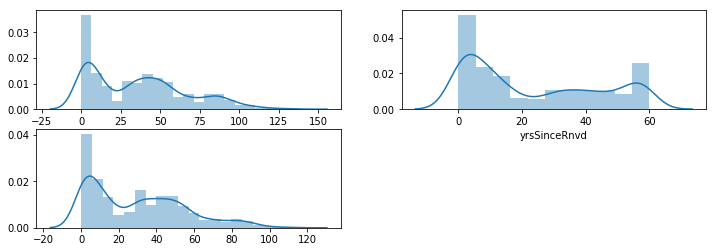

In [15]:
# histogram of the new features

plt.figure(figsize=(12,4))
plt.subplot(221)
sns.distplot(trainTest['yrsSinceBlt'])
plt.subplot(222)
sns.distplot(trainTest['yrsSinceRnvd'])
plt.subplot(223)
sns.distplot(trainTest.loc[trainTest['yrsSinceGrgBlt'].notna(),['yrsSinceGrgBlt']])

### Digging deeper

Looking at features by categorical (object) vs. numeric (float64 & int64), there are a few that need changing of their inherent data type:
- $MSSubClass$ is actually categorical
- $OverallQual$ and $OveralCond$ have 10 ordinal categories, and so will treat as a numeric variable

In [16]:
print(trainTest.select_dtypes(include = ['object']).columns)
print(trainTest.select_dtypes(exclude = ['object']).columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'dataSubset'],
      dtype='object')
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'B

In [17]:
# change data type for the three variables

trainTest['MSSubClass'] = trainTest['MSSubClass'].astype('object')
trainTest['OverallCond'] = trainTest['OverallCond'].astype('int64')
trainTest['OverallQual'] = trainTest['OverallQual'].astype('int64')

trainTest[['MSSubClass','OverallCond','OverallQual']].dtypes

MSSubClass     object
OverallCond     int64
OverallQual     int64
dtype: object

In [18]:
trainTest[['MSSubClass','OverallCond','OverallQual']].dtypes

MSSubClass     object
OverallCond     int64
OverallQual     int64
dtype: object

Need to delete some of the features because they're either redundant (1st and 2nd floor SF), not pertinent (Id), etc.

In [19]:
trainTest = trainTest.drop(columns=['Id','YearBuilt','YearRemodAdd','MoSold','YrSold'])

In [20]:
# save feature names by dtype
# for categorical, ignore dataSubset

num_features = trainTest.select_dtypes(exclude = ['object']).columns
cat_features = trainTest.loc[:, trainTest.columns != 'dataSubset'].select_dtypes(include = ['object']).columns

#### Examine distribution of categorical and numeric variables 

Several of the categorical variables either contain categories with very few instances, or show near-zero variance altogether. Without more content knowledge about how best to combine categories, and since I expect that the most effective predictive model will be within the ensemble regression tree family (which will just drop noninformative predictors), I'll only focus on those with extreme near-zero variance:
- Drop $Street$ - practically no variance
- Drop $Utilities$ - practically no variance
- Make $Alley$ a binary variable - Alley vs. No Alley
- Make $Landslope$ a binary variable - Gentle vs. Sharp
- Make $RoofMatl$ a binary variable - CompShg vs. Other

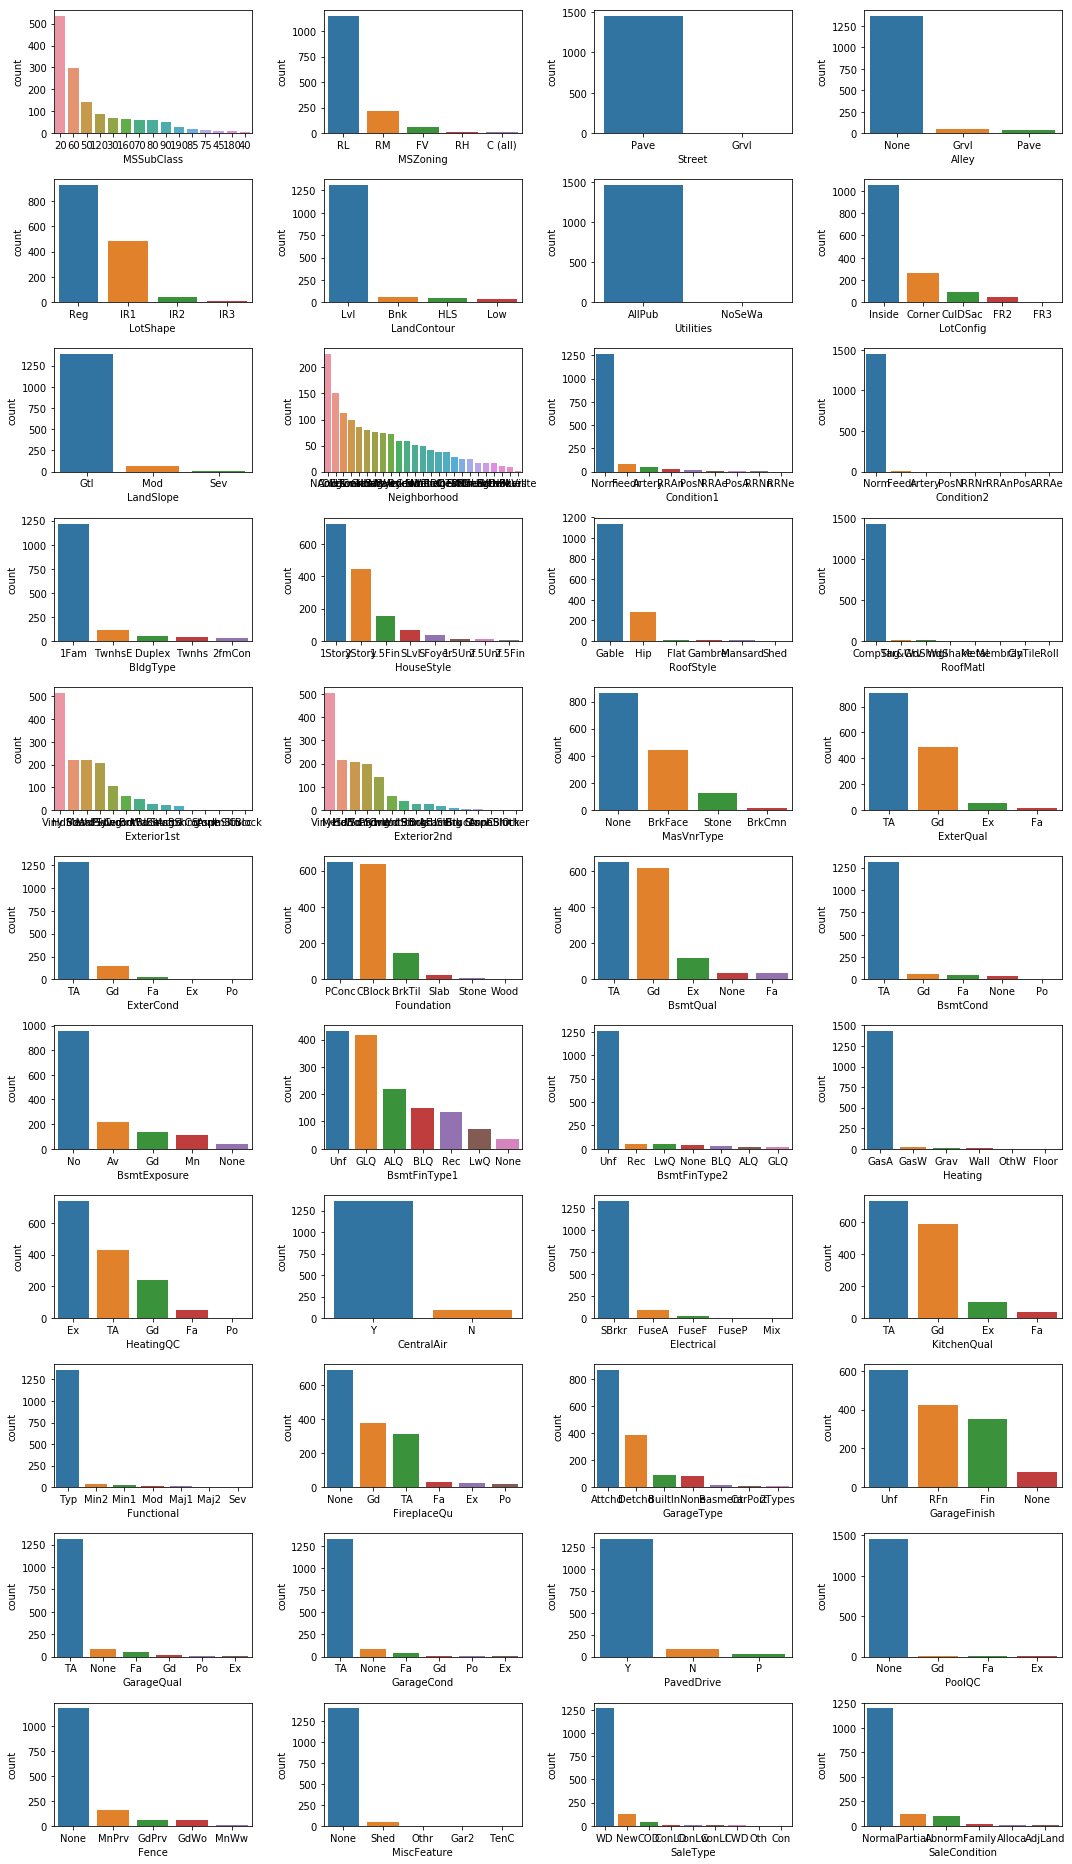

In [21]:
# create count plots of all categorical variables

plt.figure(figsize=(15,26))
for i in range(1,45):
    plt.subplot(11,4,i)
    sns.countplot(trainTest.loc[trainTest['dataSubset'] == 'train', cat_features[i-1]],
                 order = trainTest.loc[trainTest['dataSubset'] == 'train', cat_features[i-1]].value_counts().index)
    plt.tight_layout()

In [22]:
# drop Street & Utilities

trainTest = trainTest.drop(columns=['Street','Utilities'])

# Collapse variables for Alley, LandSlope, and RoofMatl

trainTest['Alley'] = np.where(trainTest['Alley'].isin(['Grvl','Pave']),'Alley','None')
trainTest['LandSlope'] = np.where(trainTest['LandSlope'].isin(['Mod','Sev']),'Harsh','Gtl')
trainTest['RoofMatl'] = np.where(trainTest['RoofMatl'] == 'CompShg','CompShg','Other')

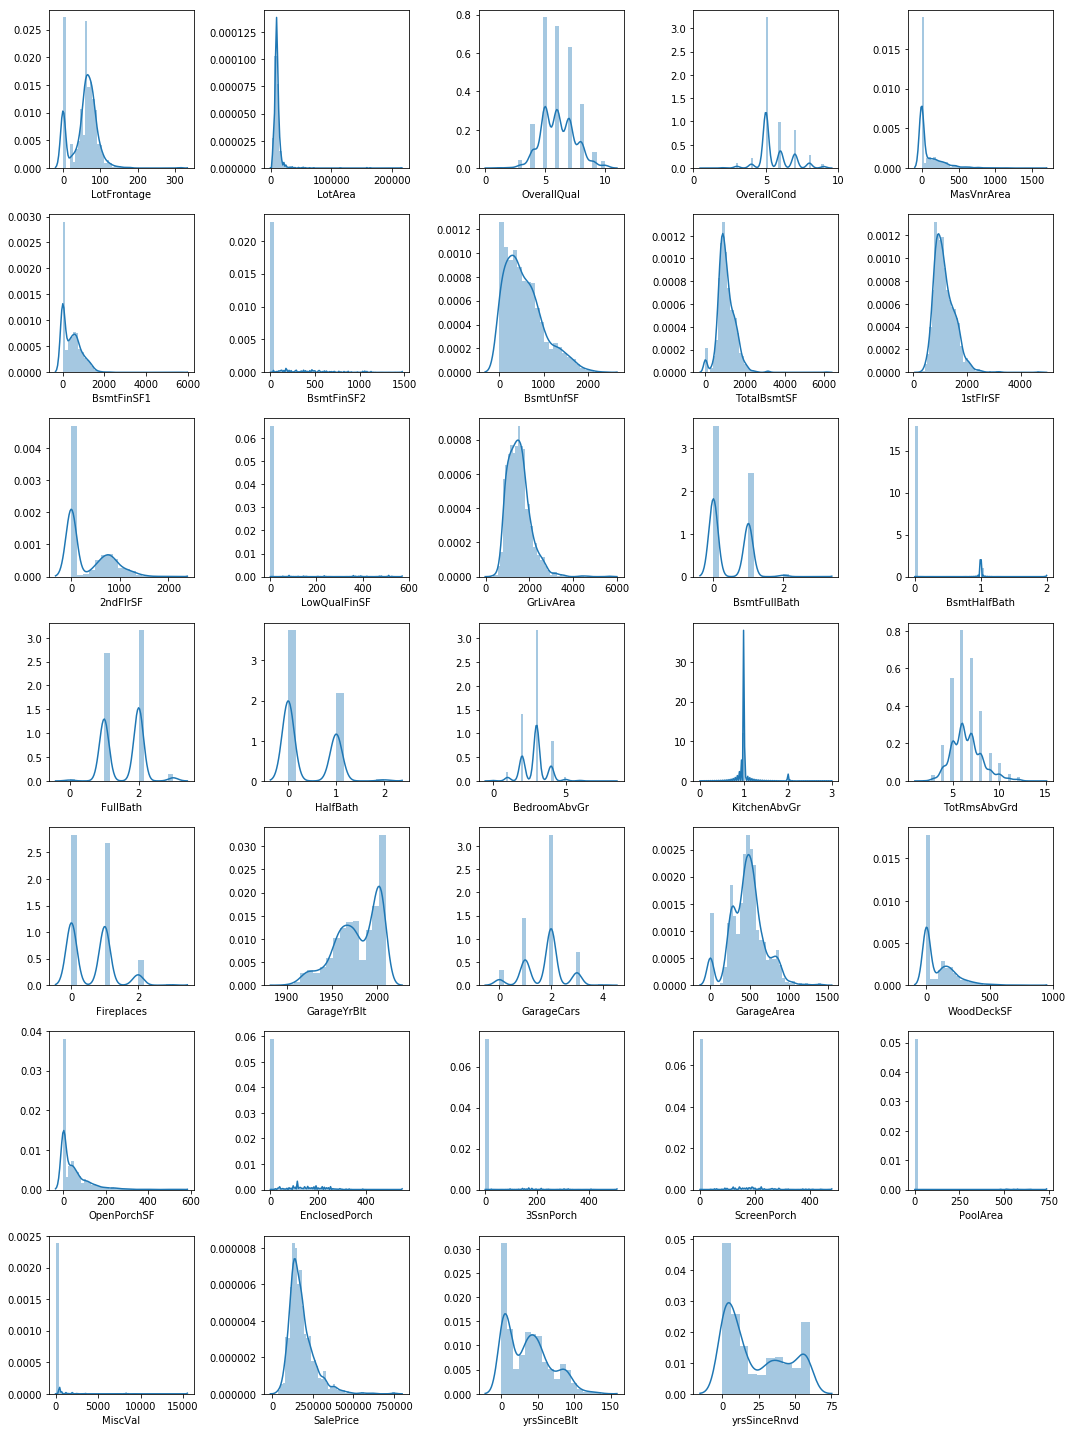

In [23]:
# create histograms for all numeric variables

plt.figure(figsize=(15,20))
for i in range(1,35):
    plt.subplot(7,5,i)
    sns.distplot(trainTest.loc[trainTest['dataSubset'] == 'train', num_features[i-1]].dropna())
    plt.tight_layout()

In [24]:
# update list of categorical variables since things changed

cat_features = trainTest.loc[:, trainTest.columns != 'dataSubset'].select_dtypes(include = ['object']).columns
num_features = trainTest.loc[:, trainTest.columns != 'dataSubset'].select_dtypes(exclude = ['object']).columns

### Association between numeric predictors and $SalesPrice$

The correlation between $SalesPrice$ and the numeric variables ranges in (absolute) magnitude from 0.04 to 0.79. The overall quality and total square feet of the house are very highly correlated with final $SalesPrice$.

In [25]:
corrYX = trainTest.loc[trainTest['dataSubset'] == 'train', num_features].corr()['SalePrice'].sort_values(axis=0,ascending=False).iloc[1:]
corrYX

OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
GarageYrBlt       0.486362
MasVnrArea        0.477493
Fireplaces        0.466929
BsmtFinSF1        0.386420
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
LotFrontage       0.209624
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
LowQualFinSF     -0.025606
OverallCond      -0.077856
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
yrsSinceGrgBlt   -0.487069
yrsSinceRnvd     -0.509096
yrsSinceBlt      -0.523350
Name: SalePrice, dtype: float64

Taking a look at a scatterplot of $GrLivArea$ and $SalesPrice$ reveals very clear outliers. In general, $SalesPrice$ exponentially increases as the total square footage of the house increases, though there are two *very* large houses that were sold *very* cheap. These points will be dropped to avoid introducing further bias.

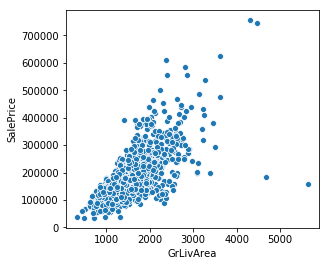

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=trainTest[trainTest['dataSubset']=='train'])

In [27]:
# identify index of observations with outliers

trainTest.loc[(trainTest['GrLivArea'] > 4000) & (trainTest['SalePrice'] < 300000),'GrLivArea']

523     4676
1298    5642
Name: GrLivArea, dtype: int64

In [28]:
# remove observations

trainTest = trainTest.drop([523,1298])

## Final preprocessing

In [29]:
# combined list of numeric and categorical features

fin_features = num_features.tolist() + cat_features.tolist()

# separate data for final processing

X_train, y_train = trainTest.loc[trainTest['dataSubset'] == 'train',fin_features], np.log(trainTest.loc[trainTest['dataSubset'] == 'train',trainTest.columns == 'SalePrice'])
X_test = trainTest.loc[trainTest['dataSubset'] == 'test',fin_features]

# dimensions/length of new objects

print(X_train.shape)
print(len(y_train))
print(X_test.shape)

(1458, 77)
1458
(1459, 77)


With the finalized features split into train/test sets, the final preprocessing steps are completed here:
1. Take care of missing values: (1) for *numeric* features, impute NaNs with median since many of the features are slightly skewed; (2) for *categorical* features, impute NaNs with the most frequent case
2. Rescale all numeric variables to have a mean of 0 and standard deviation of 1
3. One-hot encode categorical variables

To make these step more efficient, my approach is to create a pipeline to automatically apply these steps to all relevant features. The final adjusted datasets will be the input to scikit-learn models.

In [30]:
# create a pipeline 
# imputing missing values, standardizing numeric features, one hot encoding categorical variables

# numeric

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# wrap these pipelines up together using ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

# create an instance of 'preprocessor' to apply to our data

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [31]:
# apply to our data
# note: fit_transform to the training data
# but ONLY transform the test data

X_train_adj = clf.fit_transform(X_train)
X_test_adj = clf.transform(X_test)

In [32]:
# save datasets

with open("final_adj_housingData.pickle", "wb") as f:
    pickle.dump((X_train_adj,y_train,X_test_adj), f)